In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torchvision.transforms as transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomResizedCrop

from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla P100-PCIE-16GB


In [3]:
# 資料路徑設定

# dataset_folder = '/kaggle/input/micsigv1-spectrogramsamplitude/MicSigV1_Spectrograms(Amplitude)'
# dataset_folder = '/kaggle/input/micsigv1-spectrogramspower/MicSigV1_Spectrograms(Power)'
#---------------------------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-64amplitude/MicSigV1_Adaf_Spectrograms_64(Amplitude)'
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-64power/MicSigV1_Adaf_Spectrograms_64(Power)'
#---------------------------------------------------------------------------------------------------------------------
dataset_folder = '/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64'

In [4]:
# ViT for Binary Classification
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        

        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)

        # 取得原始 patch embedding 層的權重並平均
        # 在 torchvision ViT 中，這一層叫做 "conv_proj"
        original_conv_proj = self.vit.conv_proj
        original_weights = original_conv_proj.weight.detach().clone()
        new_weights = original_weights.mean(dim=1, keepdim=True) 

        out_channels = original_conv_proj.out_channels
        kernel_size = original_conv_proj.kernel_size
        stride = original_conv_proj.stride
        
        self.vit.conv_proj = nn.Conv2d(1, out_channels, kernel_size=kernel_size, stride=stride)
        self.vit.conv_proj.weight = nn.Parameter(new_weights)
        
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.vit(x)
        return self.sigmoid(x)

In [5]:
class MicSigDataset(Dataset):
    def __init__(self, transform=None):
        super(MicSigDataset, self).__init__()
        self.images = []
        self.labels = []
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
MONO_MEAN = [0.449]#新的 Mean: (0.485 + 0.456 + 0.406) / 3 ≈ 0.449
MONO_STD = [0.226]#新的 Std: (0.229 + 0.224 + 0.225) / 3 ≈ 0.226

In [7]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(), 
    transforms.Normalize(mean=MONO_MEAN, std=MONO_STD) 
])
print("Validation Transforms:\n", val_transform)

Validation Transforms:
 Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.449], std=[0.226])
)


In [8]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    RandomRotation(degrees=(-15, 15)), # 旋轉
    
    transforms.ToTensor(), 
    transforms.Normalize(mean=MONO_MEAN, std=MONO_STD)
])
print("\nTraining Transforms:\n", train_transform)


Training Transforms:
 Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.449], std=[0.226])
)


In [9]:
all_images = []
all_labels = []
for file_name in os.listdir(dataset_folder):
    if file_name.startswith("LP"):
        label = 0
    elif file_name.startswith("VT"):
        label = 1
    else:
        continue
    all_images.append(os.path.join(dataset_folder, file_name))
    all_labels.append(label)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

In [10]:
# Store metrics for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
fold_auc_scores = []

In [11]:
# Start K-Fold cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(all_images, all_labels)):
    print(f"\n===== Fold {fold + 1}/{skf.n_splits} =====")

    # 建立此 fold 的訓練和驗證資料集
    train_dataset = MicSigDataset(transform=train_transform)
    train_dataset.images = [all_images[i] for i in train_idx]
    train_dataset.labels = [all_labels[i] for i in train_idx]

    val_dataset = MicSigDataset(transform=val_transform)
    val_dataset.images = [all_images[i] for i in val_idx]
    val_dataset.labels = [all_labels[i] for i in val_idx]

    # 建立 data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ViTModel().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    # Training loop for each fold
    num_epochs = 10
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    auc_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            labels = labels.float().view(-1, 1).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)


        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_val_labels = []
        all_val_outputs = []

        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.float().view(-1, 1).to(device)
                images = images.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_outputs.extend(outputs.cpu().numpy()) # 儲存原始 logits

        val_accuracy = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        scheduler.step()
        
        auc = roc_auc_score(all_val_labels, all_val_outputs)
        auc_scores.append(auc)
        
        # Print metrics for each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, AUC: {auc:.4f}, '
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
    
    # 儲存當前 fold 訓練完成後的模型
    model_path = f'MicSigV1_ViT1_Mel_Spectrograms_64_5fold_{fold + 1}.pth'
    torch.save(model.state_dict(), model_path)
    print(f"--- Model for Fold {fold + 1} saved to {model_path} ---")
    
    # Store fold metrics
    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])
    fold_train_accuracies.append(train_accuracies[-1])
    fold_val_accuracies.append(val_accuracies[-1])
    fold_auc_scores.append(auc_scores[-1])


===== Fold 1/5 =====


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 231MB/s] 


Epoch 1/10, Train Loss: 0.2771, Train Accuracy: 0.9305, Val Loss: 0.2136, Val Accuracy: 0.9323, AUC: 0.7079, Learning Rate: 0.00000978
Epoch 2/10, Train Loss: 0.2377, Train Accuracy: 0.9305, Val Loss: 0.1952, Val Accuracy: 0.9323, AUC: 0.8754, Learning Rate: 0.00000914
Epoch 3/10, Train Loss: 0.2175, Train Accuracy: 0.9305, Val Loss: 0.1644, Val Accuracy: 0.9323, AUC: 0.9220, Learning Rate: 0.00000815
Epoch 4/10, Train Loss: 0.1641, Train Accuracy: 0.9323, Val Loss: 0.1450, Val Accuracy: 0.9549, AUC: 0.9355, Learning Rate: 0.00000689
Epoch 5/10, Train Loss: 0.1272, Train Accuracy: 0.9568, Val Loss: 0.1282, Val Accuracy: 0.9549, AUC: 0.9319, Learning Rate: 0.00000550
Epoch 6/10, Train Loss: 0.1334, Train Accuracy: 0.9530, Val Loss: 0.1317, Val Accuracy: 0.9624, AUC: 0.9256, Learning Rate: 0.00000411
Epoch 7/10, Train Loss: 0.1134, Train Accuracy: 0.9662, Val Loss: 0.1573, Val Accuracy: 0.9549, AUC: 0.9050, Learning Rate: 0.00000285
Epoch 8/10, Train Loss: 0.0943, Train Accuracy: 0.9605,

In [12]:
mean_train_loss = np.mean(fold_train_losses)
std_train_loss = np.std(fold_train_losses)
mean_val_loss = np.mean(fold_val_losses)
std_val_loss = np.std(fold_val_losses)

mean_train_acc = np.mean(fold_train_accuracies)
std_train_acc = np.std(fold_train_accuracies)
mean_val_acc = np.mean(fold_val_accuracies)
std_val_acc = np.std(fold_val_accuracies)

mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

# Print final results
print("Cross-Validation Results:")

print(f"Average Train Loss:     {mean_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Validation Loss:  {mean_val_loss:.4f} ± {std_val_loss:.4f}")

print(f"Average Train Accuracy:   {mean_train_acc*100:.2f} ± {std_train_acc*100:.2f} %")
print(f"Average Validation Acc:   {mean_val_acc*100:.2f} ± {std_val_acc*100:.2f} %")
print(f"Average Validation AUC:   {mean_auc:.2f} ± {std_auc:.2f}")
print(f"Average Validation AUC:   {mean_auc:} ± {std_auc:}")

Cross-Validation Results:
Average Train Loss:     0.1044 ± 0.0140
Average Validation Loss:  0.1332 ± 0.0109
Average Train Accuracy:   96.28 ± 1.20 %
Average Validation Acc:   94.14 ± 0.56 %
Average Validation AUC:   0.94 ± 0.01
Average Validation AUC:   0.9350100533263397 ± 0.013999056768007485


In [13]:
# 計算訓練集各類別的張數
train_class_counts = {}
for _, label in train_dataset:
    train_class_counts[label] = train_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("訓練集各類別的張數:")
for label, count in train_class_counts.items():
    print(f"類別 {label}: {count} 張")

# 計算測試集各類別的張數
test_class_counts = {}
for _, label in val_dataset:
    test_class_counts[label] = test_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("測試集各類別的張數:")
for label, count in test_class_counts.items():
    print(f"類別 {label}: {count} 張")

訓練集各類別的張數:
類別 0: 496 張
類別 1: 36 張
測試集各類別的張數:
類別 0: 123 張
類別 1: 10 張


In [14]:
# Print filenames for class 1 (VT) in the test set
vt_files = [val_dataset.images[i] for i in range(len(val_dataset)) if val_dataset.labels[i] == 1]

# Display the filenames
for file in vt_files:
    print(file)

/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT12.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT14.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT11.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT8.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT9.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT27.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT44.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT10.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT20.png
/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64/VT25.png


In [15]:
total_images = len(train_dataset) + len(val_dataset)
print(f"總共有 {total_images} 張圖片")

total_train_images = len(train_dataset)
print(f"\n訓練集的總張數: {total_train_images}")

total_test_images = len(val_dataset)
print(f"測試集的總張數: {total_test_images}")

總共有 665 張圖片

訓練集的總張數: 532
測試集的總張數: 133


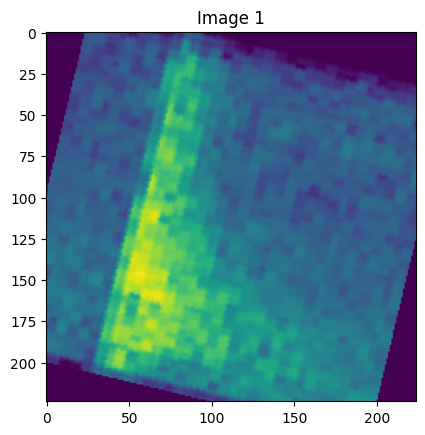

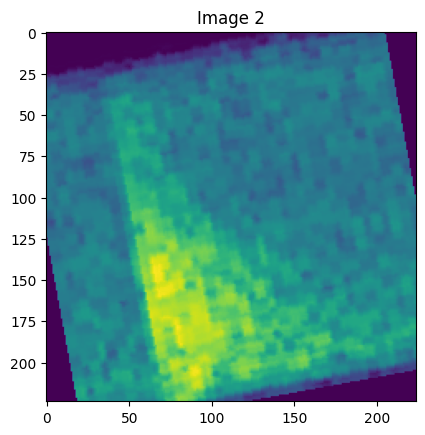

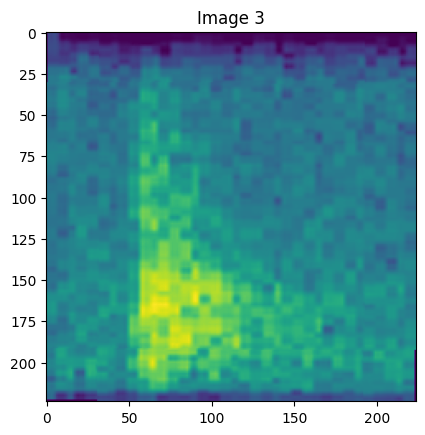

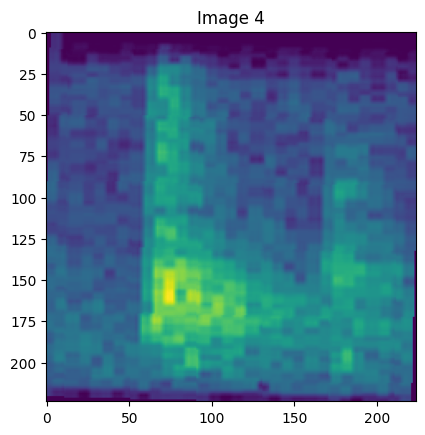

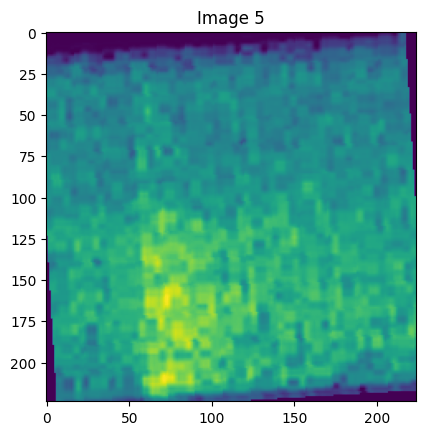

In [16]:
# Display
for i in range(5):
    image, _ = train_dataset[i]
    np_image = image.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.title(f"Image {i+1}")
    plt.show()